# Toy model evaluation of FE estimation and clustering 

In [1]:
import numpy as np
import toy_models
import GMM_FE
import matplotlib.pyplot as plt

In [10]:
toy_model = 'GMM_2D'

# Create model
if toy_model == 'mGMMs':
    tm = toy_models.MultipleGMMs()
    stack_landscapes=True
else:
    tm = toy_models.GMM2D()
    stack_landscapes=False

nx = 30
x_lims = [[0,1],[0,1]]

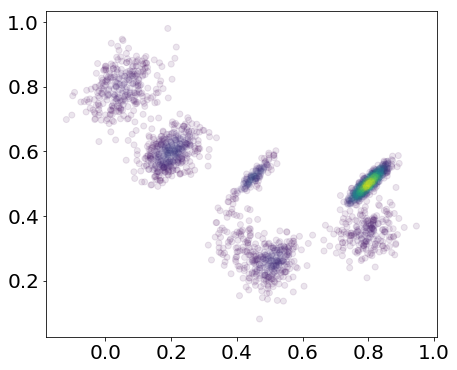

In [17]:
# Sample from model
data = tm.sample(2000)

# Compute true density at points
data_density = tm.density(data)

plt.figure(1)
plt.scatter(data[:,0],data[:,1],c=data_density,alpha=0.1)
plt.show()

Density grid shape: (30, 30)


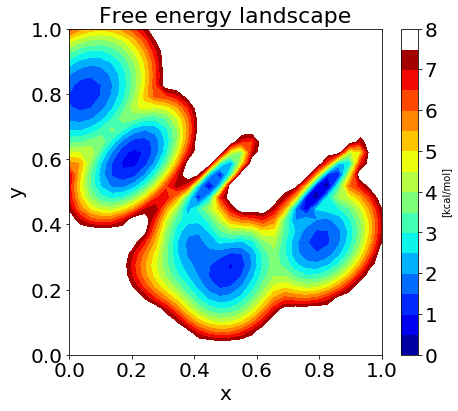

In [18]:
# Create a free energy object with known toy model
true_fe = GMM_FE.FreeEnergy(data,x_lims=x_lims,n_grids=nx,verbose=False,stack_landscapes=stack_landscapes)
true_fe.density_est_ = tm
coords, density = true_fe.density_landscape()

# Compute true free energy
FE_landscape = true_fe._free_energy(density)
min_FE = np.min(FE_landscape)
FE_landscape = FE_landscape-min_FE

FE_points = true_fe._free_energy(data_density)-min_FE

# Set true free energies
true_fe.coords_ = coords
true_fe.FE_landscape_ = FE_landscape
true_fe.FE_points_ = FE_points

# Visualize the model
true_fe.visualize(show_data=False)

In [16]:
# Cluster data
labels, cluster_centers = true_fe.cluster(coords,FE_points,data)

Clustering free energy landscape...
Computing Hessians.
Constructing connected components.
# Graph connections: 66.0
Clustering data points.
Cluster labels: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]
Done clustering.


[4175 5211 5941  681 4310  791 5421 6536 2690 6881 1583 5557 5311]


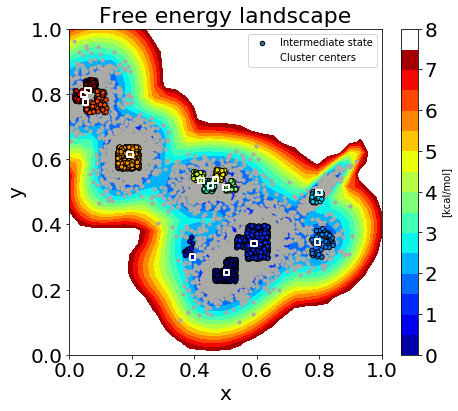

In [17]:
# Visualize true clusters
true_fe.visualize(show_data=True)
print(cluster_centers)

In [21]:
# Estimate free energy and clustering with GMM and cross-validation
stack_landscapes = True

gmm_FE = GMM_FE.FreeEnergy(data,min_n_components=6,max_n_components=25, n_components_step=2, x_lims=true_fe.x_lims_, 
                           n_grids=true_fe.nx_, stack_landscapes=stack_landscapes, n_iterations=3, covergence_tol=1e-6)

est_coords, est_FE_landscape, est_FE_points = gmm_FE.landscape()

*----------------Gaussian mixture model free energy estimator----------------*
   n_splits = 3
   shuffle_data = False
   n_iterations = 3
   n_grids = 30
   covergence_tol = 1e-06
   stack_landscapes = True
   x_lims (axes limits) = [[0, 1], [0, 1]]
   temperature = 300.0
   min_n_components = 6
   max_n_components = 25
*----------------------------------------------------------------------------*
Estimating density with stacked GMMs.
# Components = 6
Summed validation set log-likelihood: 6.173519892744371
# Components = 8
Summed validation set log-likelihood: 6.240704168206795
# Components = 10
Summed validation set log-likelihood: 6.172282548738726
# Components = 12
Summed validation set log-likelihood: 6.161038017832647
# Components = 14
Summed validation set log-likelihood: 6.188844463301677
# Components = 16
Summed validation set log-likelihood: 6.158771054014583
# Components = 18
Summed validation set log-likelihood: 6.15717369534399
# Components = 20
Summed validation set log-l

Density grid shape: (30, 30)
Density grid shape: (30, 30)
Density grid shape: (30, 30)
Density grid shape: (30, 30)
Density grid shape: (30, 30)
Density grid shape: (30, 30)
Density grid shape: (30, 30)
Density grid shape: (30, 30)
Density grid shape: (30, 30)
Density grid shape: (30, 30)


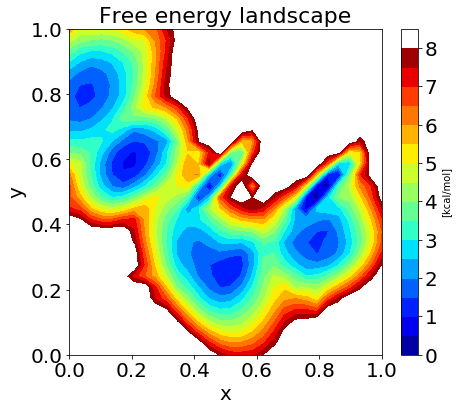

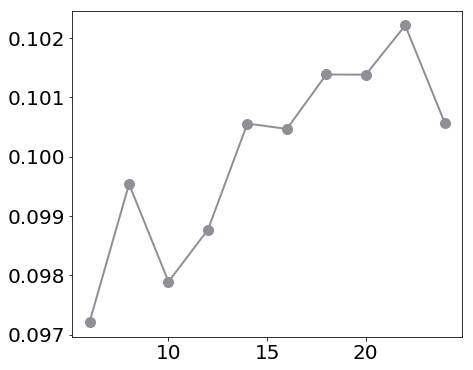

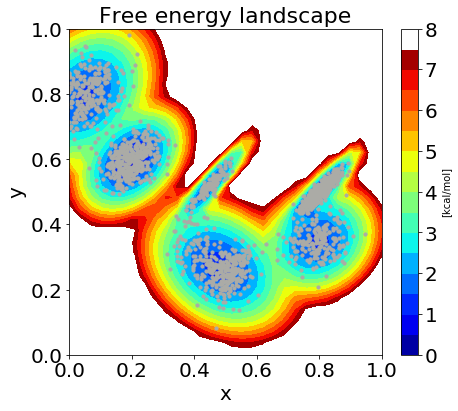

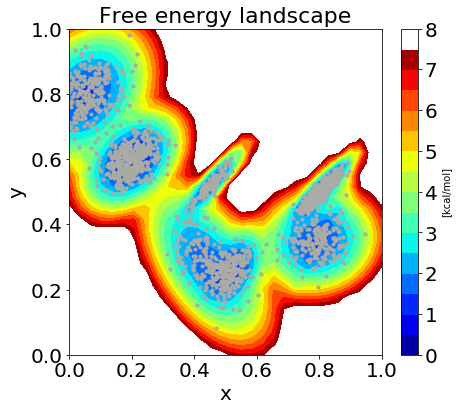

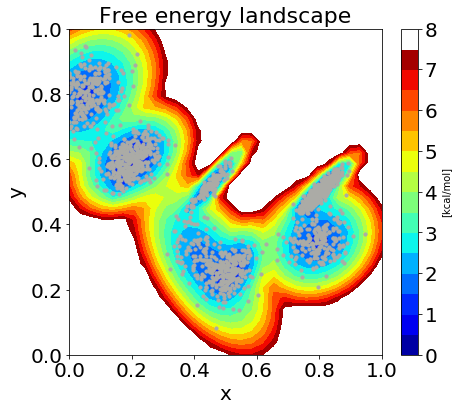

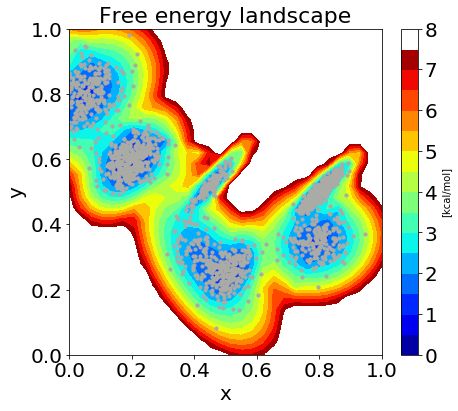

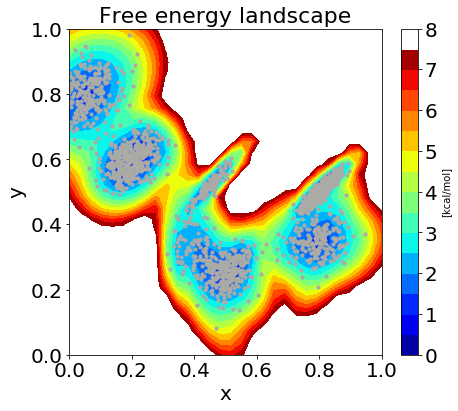

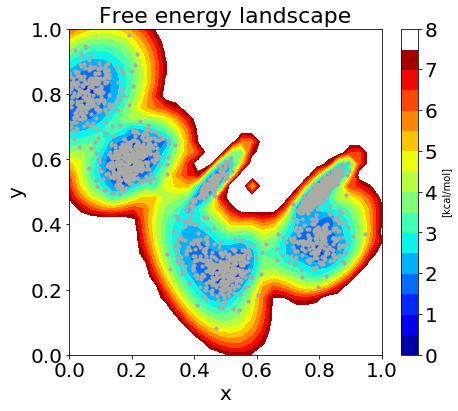

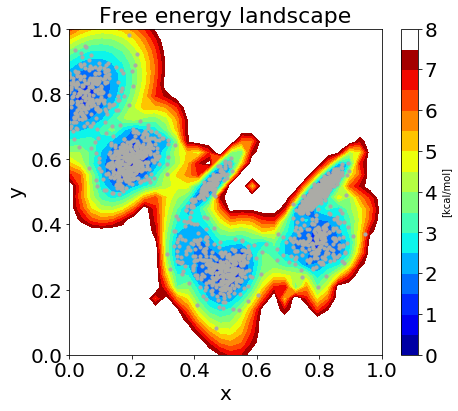

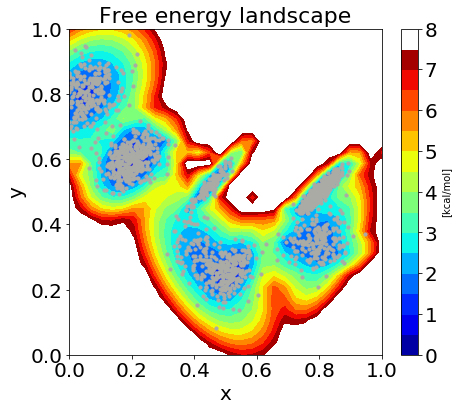

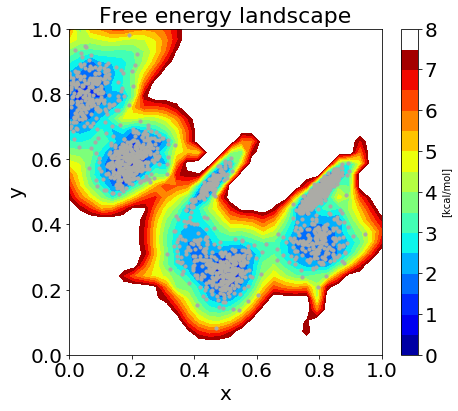

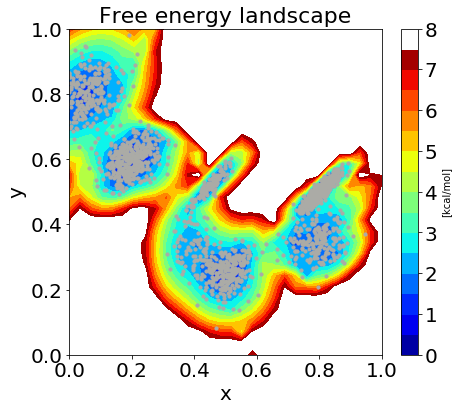

In [22]:
# Visualize estimated free energy landscape and the true free energy contours
gmm_FE.visualize(show_data=False,vmax=8,n_contour_levels=20)
#plt.contour(coords[0],coords[1],true_fe.FE_landscape_,colors=['k'],vmax=8,levels=np.arange(0,8,0.8))

if stack_landscapes:
    # Plot the model weights
    plt.figure(2)
    plt.plot(gmm_FE.density_est_.n_components_list_,gmm_FE.density_est_.model_weights_,linewidth=2,marker='o',color=[0.56,0.56,0.6],markersize=10)
    
    # Plot each indivudual model
    n_models = gmm_FE.density_est_.n_models_
    for i_model in range(n_models):
        # Create a free energy object with known toy model
        mod_fe = GMM_FE.FreeEnergy(data,x_lims=true_fe.x_lims_,n_grids=true_fe.nx_,verbose=False)
        mod_fe.density_est_ = gmm_FE.density_est_.GMM_list_[i_model]
        mod_coords, density = mod_fe.density_landscape()
        
        # Compute true free energy
        mod_FE_landscape = mod_fe._free_energy(density)
        mod_min_FE = np.min(mod_FE_landscape)
        mod_FE_landscape = mod_FE_landscape-mod_min_FE

        # Set true free energies
        mod_fe.coords_ = mod_coords
        mod_fe.FE_landscape_ = mod_FE_landscape

        # Visualize the model
        mod_fe.visualize(show_data=True)

In [7]:
# Cluster based on estimated density model
est_labels, est_cluster_centers = gmm_FE.cluster(est_coords,est_FE_points,data)

Clustering free energy landscape...
Computing Hessians.
Constructing connected components.
# Graph connections: 74.0
Clustering data points.
Cluster labels: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Done clustering.


[5004  298  471 3695 1722 2532 6466 1783 5145 1467]
[5004  298  471 3695 1722 2532 6466 1783 5145 1467]


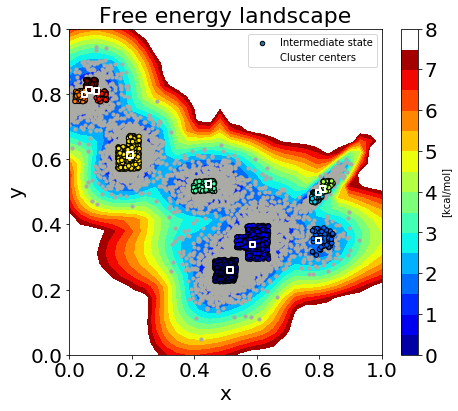

In [8]:
print(gmm_FE.cluster_centers_)
gmm_FE.visualize(show_data=True)
print(est_cluster_centers)
if not(stack_landscapes):
    print(gmm_FE.density_est_.n_components_)

In [30]:
tm_eval = toy_models.MethodEvaluator(x_lims=[[0,1],[0,1]])
tm_eval.run_evaluation(5, 4000, n_iterations=3, min_n_components=7, max_n_components=18, n_splits=3)

Setting true model.
Density grid shape: (30, 30)
*----------------Gaussian mixture model free energy estimator----------------*
   n_splits = 3
   shuffle_data = False
   n_iterations = 3
   n_grids = 30
   covergence_tol = 1e-06
   stack_landscapes = False
   x_lims (axes limits) = [[0, 1], [0, 1]]
   temperature = 300.0
   min_n_components = 7
   max_n_components = 18
*----------------------------------------------------------------------------*
*----------------Gaussian mixture model free energy estimator----------------*
   n_splits = 3
   shuffle_data = False
   n_iterations = 3
   n_grids = 30
   covergence_tol = 1e-06
   stack_landscapes = True
   x_lims (axes limits) = [[0, 1], [0, 1]]
   temperature = 300.0
   min_n_components = 7
   max_n_components = 18
*----------------------------------------------------------------------------*
Estimating density with GMM.
# Components = 7
Summed validation set log-likelihood: 6.135195643209595
# Components = 8
Summed validation set log-l

KeyboardInterrupt: 

In [31]:
print(tm_eval.FE_errors_GMM_CV_)
print(tm_eval.FE_errors_mix_models_)

[0.44930979 0.52125814 0.         0.         0.        ]
[0.49056041 0.49984672 0.         0.         0.        ]
